<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ol class="toc-item">
    <li> Загрузка данных и их подготовка к анализу </li>
    <li> Функции для расчета и анализа LTV, ROI, удержания и конверсии </li>
    <li> Исследовательский анализ данных </li>
    <li> Маркетинг </li>
    <li> Оценка окупаемости рекламы для привлечения пользователей </li>
    <li> Общий вывод </li>
</oанализуl></div>

# Загрузка данных и их подготовка к анализу
Загрузим данные о визитах, заказах и расходах в переменные. Оптимизируем данные для анализа. Убедимся, что тип данных в каждой колонке — правильный: все даты в формате datetime, все числовые значения - в формате int или float, это важно для дальнейших расчётов, экономии памяти и скорости обработки функций.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# в '' прописываем наименования csv-файлов с данными
visits = pd.read_csv('')
orders = pd.read_csv('')
costs = pd.read_csv('')

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
#приводим наименования столбцов к правильному формату
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})

orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

costs.columns = costs.columns.str.lower()

In [6]:
#приводим колонки с датами к формату datetime:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Обработка данных завершена, пропусков в датафреймах не обнаружено, данные приведены к соответствующим форматам, строковые значения в формате object, числовые - float и int, даты - datetime.

# Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [7]:
#задаём функцию, чтобы построить датафрейм с профилями пользователей, она нужна для корректной работы функций для расчёта и 
#анализа LTV, ROI, удержания и конверсии: 
def get_profiles(visits, orders, costs):
    profiles = (visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first', 'region': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles 

In [8]:
#задаём функцию для расчёта удержания пользователей get_retention()
def get_retention(profiles, visits, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                            
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

In [9]:
#задаём функцию фильтрации для сглаживания графиков
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#задаём функцию построения графиков удержания plot_retention()
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()

In [10]:
#задаём функцию для расчёта конверсии пользователей в плательщиков get_conversion()
def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_orders = orders.sort_values(by=['user_id', 'event_dt']).groupby('user_id').agg({'event_dt': 'first'}).reset_index()
    result_raw = result_raw.merge(first_orders[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

In [11]:
#задаём функцию построения графиков конверсии plot_conversion()
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [12]:
#задаём функцию для расчёта дохода от пользователя LTV и инвестиций на рекламу ROI get_ltv()
def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'}))
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time

In [13]:
#задаём функцию для построения графиков экономики одного покупателя plot_ltv_roi()
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):
    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

In [14]:
#строим датафрйм с профилями пользователей
#events = None

profiles = get_profiles(visits, orders, costs)
profiles.head(15)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [15]:
#определяем минимальную дату привлечения пользователей
profiles['dt'].min()

datetime.date(2019, 5, 1)

In [16]:
#определяем максимальную дату привлечения пользователей
profiles['dt'].max()

datetime.date(2019, 10, 27)

Выясним, из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

In [17]:
# сгруппируем датафрейм с пользователями по количеству посетителей в каждой стране
profiles.groupby('region').agg({'user_id': 'count'}).sort_values(by='user_id', ascending = False)

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


In [18]:
#сгруппируем датафрейм с пользователями по среднему количеству платящих пользователей в каждой стране
profiles.groupby('region').agg({'payer': 'mean'}).sort_values(by='payer', ascending = False)

,payer
region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


Больше всего платящих пользователей дают США, наибольшее количество пользователей приходит также из США, при этом Германия на последнем месте по общему количеству посетителей и на втором месте по количеству платящих пользователей.

Теперь выясним, какими устройствами пользуются пользователи? С каких устройств чаще всего заходят платящие пользователи?

In [19]:
# сгруппируем датафрейм с пользователями по количеству посетителей с каждого вида устройства
profiles.groupby('device').agg({'user_id': 'count'}).sort_values(by='user_id', ascending = False)

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


In [20]:
#сгруппируем датафрейм с пользователями по среднему количеству платящих пользователей с каждого вида устройства
profiles.groupby('device').agg({'payer': 'mean'}).sort_values(by='payer', ascending = False)

,payer
device,
Mac,0.063644
iPhone,0.062079
Android,0.058518
PC,0.050468


Чаще всего пользователи заходят в приложение с iPhone и Android, а вот платящие пользователи чаще заходят с Mac, возможно, что приложение для телефона не очень корректно работает с оплатами, поэтому мы видим такую статистику. Правда, при этом количество платящих пользователей, которые заходят в приложение с PC - наименьшее, возможно, что приложении наиболее удобно именно для "яблочников", а не для пользователей устройств на базе Android.

Далее выясним, по каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [21]:
# сгруппируем датафрейм с пользователями по количеству посетителей, привлечённых по каждому рекламного каналу
profiles.groupby('channel').agg({'user_id': 'count'}).sort_values(by='user_id', ascending = False)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


In [22]:
#сгруппируем датафрейм с пользователями по среднему количеству платящих пользователей, привлечённых по каждому рекламного каналу
profiles.groupby('channel').agg({'payer': 'mean'}).sort_values(by='payer', ascending = False)

,payer
channel,
FaceBoom,0.122049
AdNonSense,0.113402
lambdaMediaAds,0.104700
TipTop,0.096007
RocketSuperAds,0.079137
WahooNetBanner,0.052964
YRabbit,0.038265
MediaTornado,0.035747
LeapBob,0.030633


Видим, что наибольшее количество так называемых «органических» пользователей, которые переходят в приложение самостоятельно, а не благодаря рекламе, при этом среди таких пользователей наименьшее количество платящих. Наибольшее количество платящих пользователей привлекает рекламный канал FaceBoom.
Затраты на привлечение органических пользователей нулевые, поэтому они всегда окупаются. Значит, мы можем исключить их, удалив из результата все строки, в которых размер когорты равен бесконечности, применяя метод `isin()` и оператор `~` в функции get_ltv().


# Маркетинг

Выясним, сколько денег потратили? Всего / на каждый источник / по времени

In [23]:
costs['costs'].sum()

105497.30000000002

In [24]:
costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').sort_values(by = 'costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


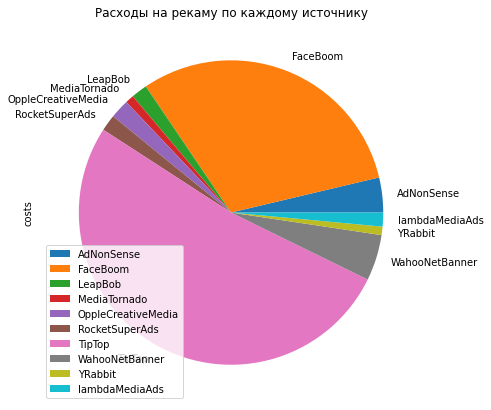

In [25]:
costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum').plot(
    y='costs', kind='pie', figsize=(15,7), title = 'Расходы на рекаму по каждому источнику')
plt.show()

В общей сложности на рекламу было потрачено  примерно 105497,3 у.е. Наибольший расход на рекламу на канале TipTop.

Визуализируем изменения метрик во времени.

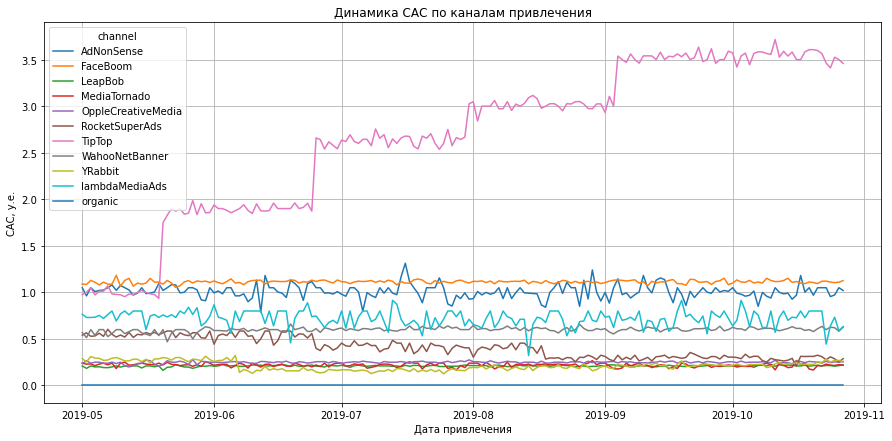

In [26]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(15, 7))
plt.ylabel('CAC, у.е.')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Видим несколько довольно резких "подъёмов" кривой,которая иллюстрирует расходы на рекламу по каналу TipTop, остальные рекламные каналы не имеют таких подъёмов, возможно имеет смысл разобраться с расходами на этом канале, возможно в них и кроетс причина неблагоприятной ситуации в компании.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Используем профили пользователей.

In [27]:
#выведем информацию о средней стоимости привлечения пользователя из каждого источника
profiles.groupby('channel').agg({'user_id': 'count', 'acquisition_cost': 'mean'}).rename(columns={'user_id': 'users_quantity'}).sort_values(by='acquisition_cost', ascending = False)

,users_quantity,acquisition_cost
channel,,
TipTop,19561,2.799003
FaceBoom,29144,1.113286
AdNonSense,3880,1.008054
lambdaMediaAds,2149,0.724802
WahooNetBanner,8553,0.602245
RocketSuperAds,4448,0.412095
OppleCreativeMedia,8605,0.250000
YRabbit,4312,0.218975
MediaTornado,4364,0.218717


In [28]:
#выведем информацию о среднем CAC на одного пользователя для всего проекта
profiles['acquisition_cost'].mean()

0.7032778251827625

Наибольшая средняя стоимость привлечения одного пользователя на каналах TipTop, FaceBoom, AdNonSense, средняя стоимость привлечения на этих каналах превышает среднюю стоимость привлечения по всем каналам в общем в разы(например, на канале TipTop стоимость привлечения выше почти в 4 раза, чем средняя по всем каналам). При этом стоимость привлечения на канале FaceBoom в 2,5 раза ниже, чем на канале TipTop, а количество привлечённых пользователей с канала FaceBoom в 1,5 раза превышает количество привлечённых пользователей с канала TipTop. А самое большое количество привлечённых пользователей на канале organic, т.е. пользователей, скачавших приложение без какой-либо рекламы. Что касается каналов AdNonSense и lambdaMediaAds, то стоимость привлечения на них выше средней, а количество привлечённых пользователей в разы меньше, чем на каналах с меньшей стоимостью привлечения (например, каналы WahooNetBanner, OppleCreativeMedia привлекают в 2-4 раза больше пользователей).

# Оценка окупаемости рекламы для привлечения пользователей


### Проанализируем общую окупаемость рекламы

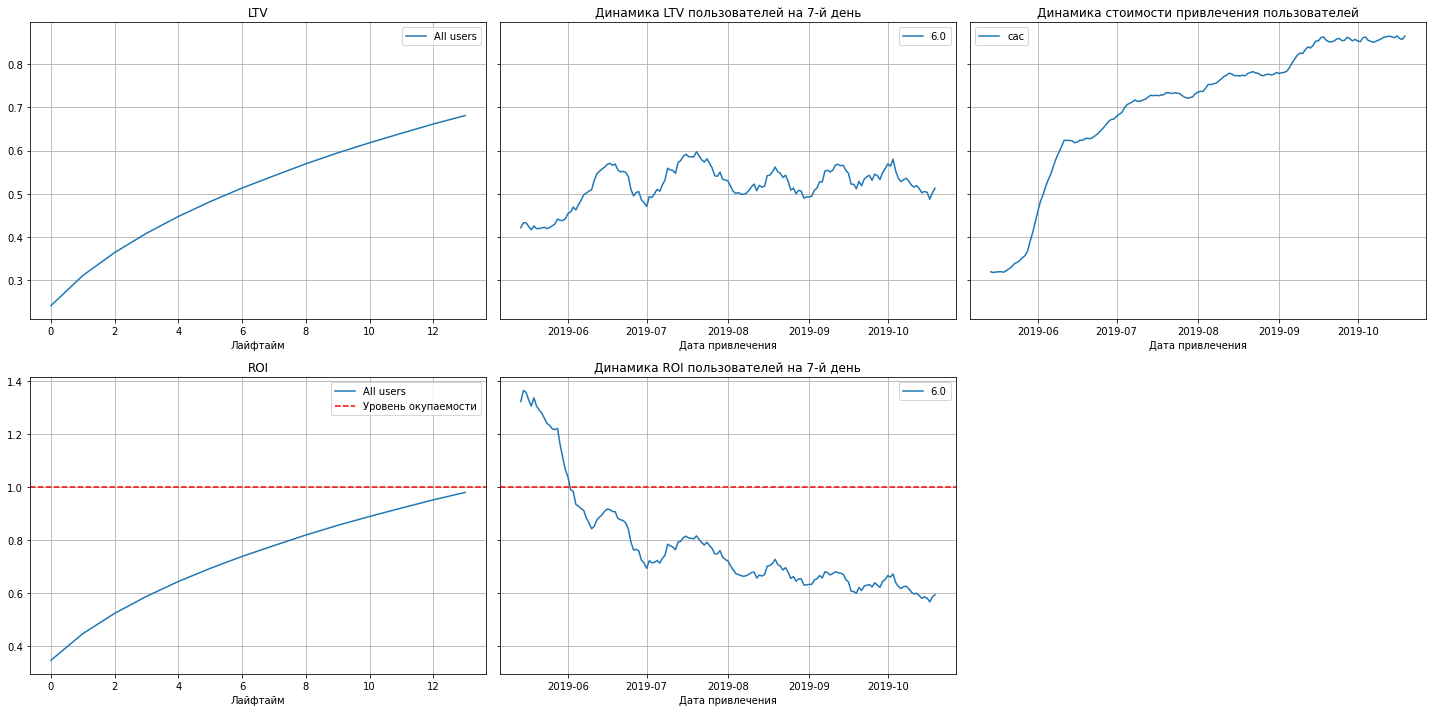

In [29]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7) 

Видим, что в целом, «пожизненная ценность» (LTV) пользователей растёт, однако, если анализировать LTV за первые 7 дней после регистрации, то мы увидим, что июле-августе "пожизненная ценность" была несколько выше, чем в последующие месяцы. Что касается расходов на рекламу CAC, то они продолжают расти с гораздо бОльшей динамикой, чем LTV, что логично приводит к тому, что в общем по всем каналам инвестиции на рекламу ROI не окупаются даже за 13 месяцев, а динамика уменьшения окупаемости рекламы за первые 7 дней после регистрации пользователя лишь подтверждает факт того, что расходы на рекламу, после июня 2019 распределяются неверно, все последующие месяцы показывают, что инвестиции в течение первых 7 дней не окупались.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

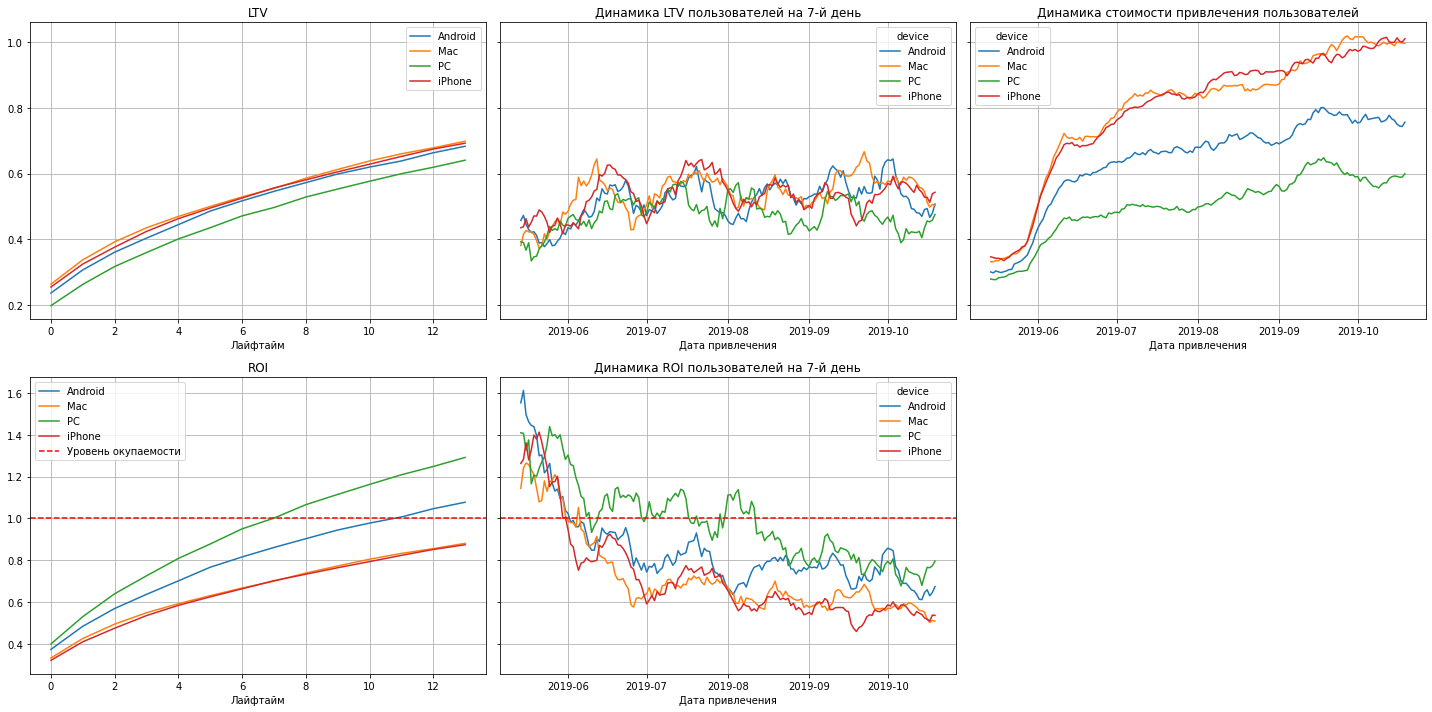

In [30]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'],
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7) 

Видим, что LTV и ROI показывают плавный рост в течение 13 месяцев, при этом бОльшую "пожизненную" ценность демонстрируют пользователи iPhone и Mac, а инвестиции быстрее всего (на 7-й месяц) окупаются по пользователям PC и на 11 месяц по пользователям Android, а вот инвестиции по пользователям Mac, iPhone не окупаются даже по прошествии 13 месяцев.
Что касается динамики LTV за первые 7 дней после регистрации, то тут наблюдается примерно схожая картина по пользователям всех устройств, елинственное, что "всплески" кривой наблюдаются чуть раньше по пользователям Mac и iPhone, чем по пользователям PC и Android, а у пользователей PC вообще наблюдается спад к октябрю. Кривая динамики CAC показывает, что расходы на рекламу для пользователей Mac и iPhone растут гораздо быстрее, чем по пользователям Android и, тем более PC. Кривая динамики ROI демонстрирует, что расходы на инвестиции окупались по пользователям всех устройств только мае-июне, а потом окупались инвестиции на рекламу только для пользователей PC, правда, после августа перестали окупаться инвестиции и для пользователей PC. Судя по тому, что общая картина экономики пользователей и картина с разбивкой по устройствам примерно схожа, предполагаю, что ключевой проблемой являются всё-таки не устройства, с которых заходят пользователи.
Хотя, скорее всего, имеет смысл обратить внимание на слишком высокие расходы на рекламу для пользователей Apple.

### Проанализируем окупаемость рекламы с разбивкой по странам

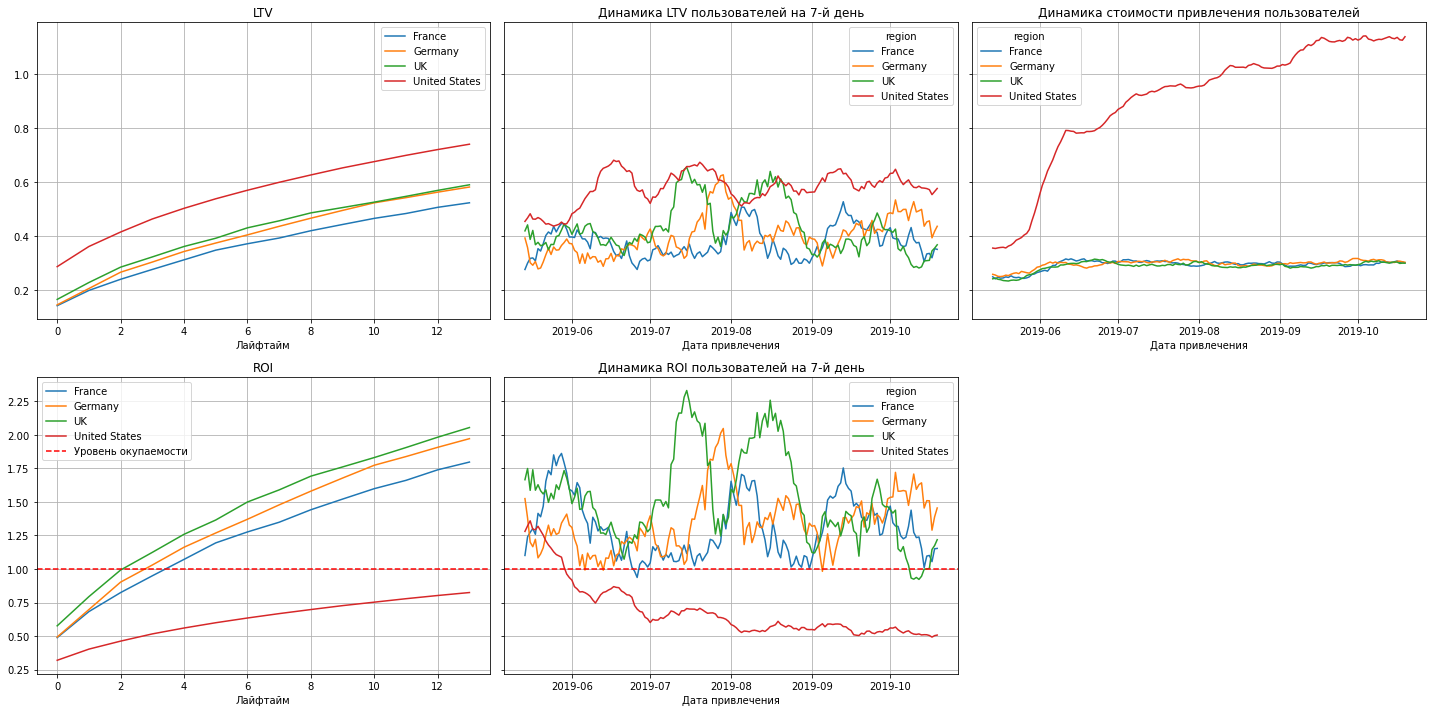

In [31]:
# считаем LTV, CAC и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'],
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7) 

Видим, что несмотря на то, что "пожизненная ценность" пользователей из США в разы выше "пожизненной ценности" представителей из Германии, Великобритании и, тем более, Франции, инвестиции на рекламу в США не окупаются по прошествии 13 месяцев, в то время, как в других странах(Великобритания, Германия, Франция) инвестиции окупаются спустя 2-3 месяца. Также видим, что кривая LTV показывает "всплески" в июле-августе по пользователям из Германии, Великобритании и Франции, а к октябрю возвращается на уровень мая-июня, при этом кривая LTV по пользователям из США показывает, что пользователи из США приносят бОльшую "пожизненную ценность", чем пользователи из других стран, правда, кажется, после октября кривая по пользователям из США также будет иметь тенденцию к снижению. Кривая CAC показывает интенсивный рост расходов на рекламу для пользователей из США в то, время как расходы на рекламу для пользователей из других стран остаются примерно на одном и том же уровне, начиная с июня, такое ощущение, что маркетинговый отдел вкладывался только в рекламу для пользователей из США.
При этом кривая динамики ROI показывает, что такие действия, видимо, были ошибочными, так как инвестиции на рекламу для пользователей из США окупались в течение первых 7 дней только в мае-июне.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

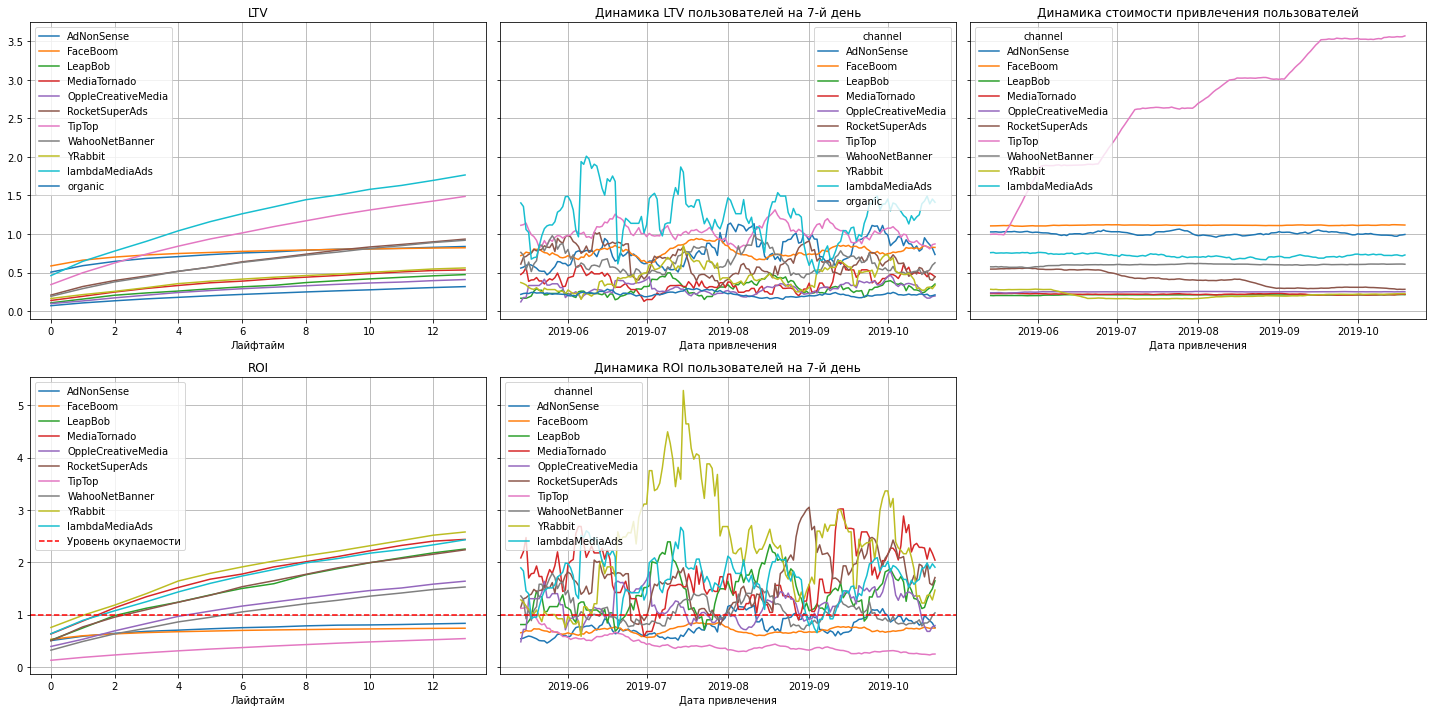

In [32]:
# считаем LTV, CAC и ROIс
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'],
)

# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 7) 

Видим, что инвестиции быстрее всего окупаются на каналах YRabbit, MediaTornado, IambdaMediaAds (спустя 1-1,5 месяца), чуть позже (спустя 2-2,5 месяца) окупаются инвестиции по каналам LeapBob и RocketSuperAds, на 4-5 месяцы окупается реклама на каналах OppleCreativeMedia и WahooNetBanner. А вот самая дорогостоящая реклама на каналах TipTop, FaceBoom и AdNonSense не окупается даже по прошествии 13 месяцев. При этом "пожизненная ценность" пользователей, пришедших с каналов IambdaMediaAds и TipTop самая высокая. Кривая динамики LTV также помогает выделить канал IambdaMediaAds, тут наблюдаются "всплески" активности в мае-июле, также высокая "пожизненная ценность" у пользователей, пришедших с канала TipTop. Кривая динамики CAC по каналу TipTop также обращает на себя пристальное внимание, там какой-то огромный рост расходов по сравнению с другими каналами. На кривой динамики ROI можно обратить внимание на пик графика канала YRabbit, в июле инвестиции на рекламу по этому каналу окупились в течение 7 дней с большим профитом. 

Проанализировав окупаемость рекламы по таким параметрам, как устройства, с которых пользователи заходят и регистрируются в приложении, регион проживания пользователей, а также рекламный канал, с которого пользователи пришли и скачали приложение, можно сделать некоторые предварительные выводы:
- "пожизненная ценность" клиентов растёт меньше, чем расходы на рекламу
- расходы на рекламу окупились в течение первых 7 дней только в мае-июне, дальше что-то пошло не так
- инвестиции на рекламу лучше всего окупаются на пользователям PC
- реклама, рассчитанная на пользователей Apple, слишком дорогая и не окупается даже в течение 13 месяцев
- реклама, рассчитанная на пользователей из США, также слишком дорогая и тоже не окупается даже в течение 13 месяцев
- реклама на канале TipTop тоже очень дорогая и не окупается в течение 13 месяцев
- реклама на канале YRabbit окупается очень хорошо и быстро(в течение первых 7 дней), расходы на неё невысоки

Построим и изучим графики удержания с разбивкой по устройствам.

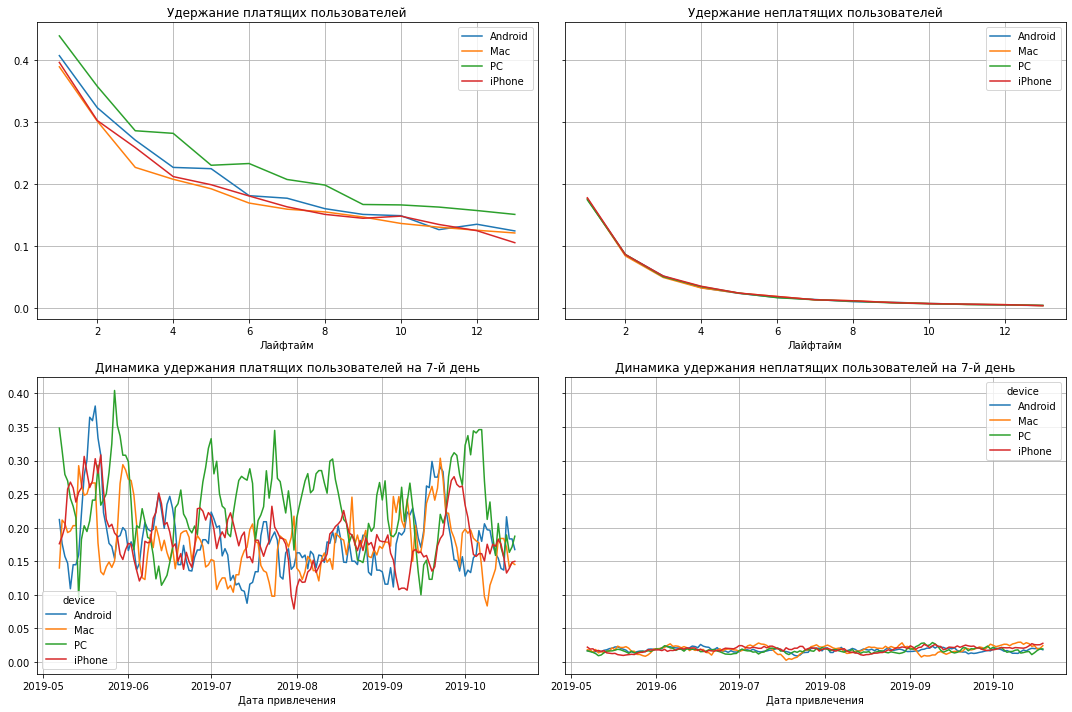

In [33]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device'])
   
plot_retention(retention, retention_history, 7) 

С неплатящими пользователями, в целом, всё ясно, картинка схожа по пользователям всех устройств, динамика удержания таких пользователей близка к нулю уже на 7-й день после регистрации. Что касается платящих пользователей, то наилучшие показатели демонстрируют снова пользователи PC, кривая динамики удержания этих пользователей показывает "всплески" практически в каждом месяце. С пользователями остальных устройств дела обстоят значительно хуже.

Проанализируем графики удержания по регионам проживания пользователей.

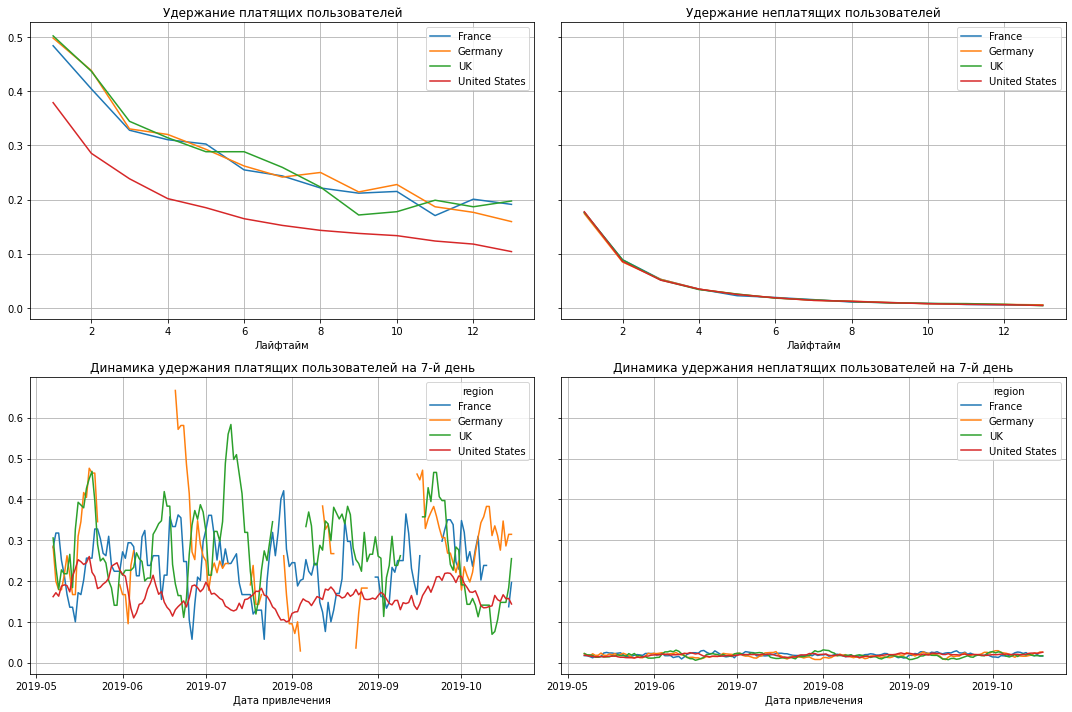

In [34]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region'])
   
plot_retention(retention, retention_history, 7) 

Платящие пользователи из США ожидаемо демонстрируют наихудшую картинку, процент удержания этих пользователей самый низкий, в разы меньше, чем у пользователей из Великобритании, Германии Франции. Также обращает на себя прерывистость кривой удержания платящих пользователей из Германии, в некоторые месяцы платящие пользователи вообще не задерживаются в приложении, это дольно странно, также есть разрывы кривых по платящим пользователям из Франции и Великобритании в сентябре, возможно что-то произошло с приложением в этот момент времени. По неплатящим пользователям картинка в целом ясна, показатели удержания на 7-й день после регистрации очень низки и близки к нулю.

Построим графики удержания с разбивкой по рекламным каналам.

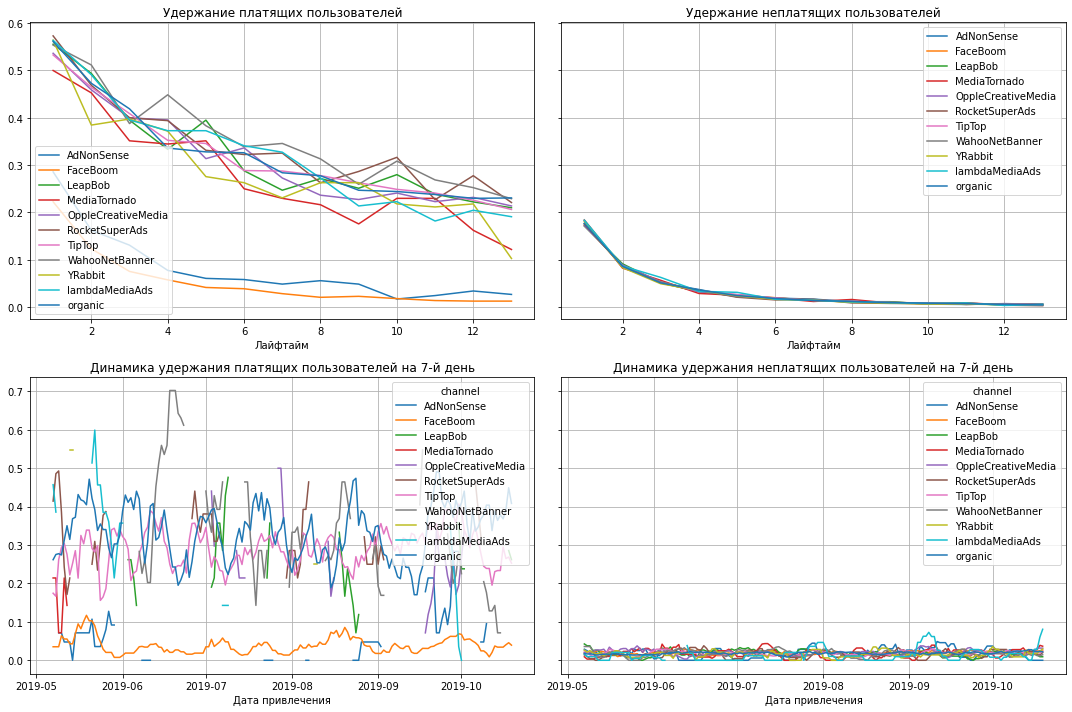

In [35]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])
   
plot_retention(retention, retention_history, 7) 

Наихудшие показатели по удержанию пользователей демонстрируют каналы AdNonSense и FaceBoomб также обращает на себя внимание прерывистость кривых динамики по каналам WahooNetBanner, RocketSuperAds, IambdaMediaAds, в некоторые месяцы эти каналы демонстрируют высокий уровень удержания пользователей, а в некоторые, наоброт, резкий спад. Кривая динамики удержания по каналу FaceBoom показывает стабтльно низкий уровень удержания пользователей. На графике удержания неплатящих пользователей обращает на себя внимание канал IambdaMediaAds, есть некоторые "всплески" в сентябре-октябре, значит, возможно,даже неплатящих пользователей заинтересовала реклама, размещённая на канале в этот период.

Построим и изучим графики конверсии с разбивкой по устройствам, странам, рекламным каналам.

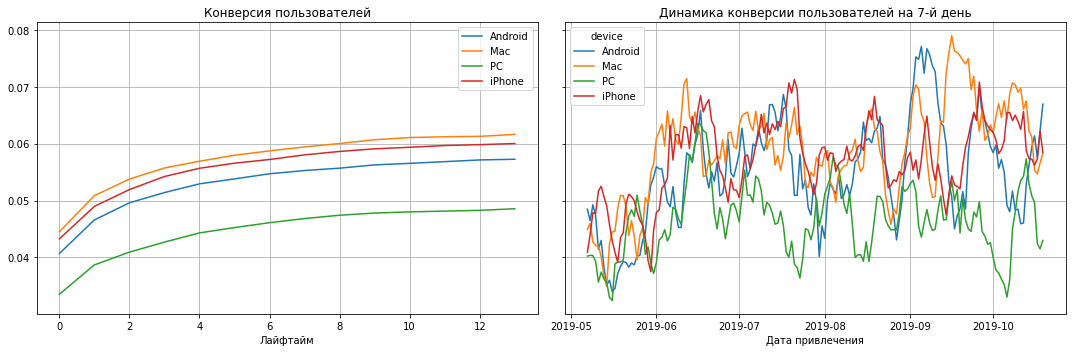

In [36]:
#разбивка по устройствам
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])
plot_conversion(conversion, conversion_history, 7)

Наибольший уровень конверсии демонтрируют пользователи Apple, наименьший, как ни странно, пользователи PC.
На кривой динамики конверсии можем наблюдать "всплески" конверсионной активности в июне дл пользователей всех устройств и   в сентябре - для всех пользователей, кроме PC.

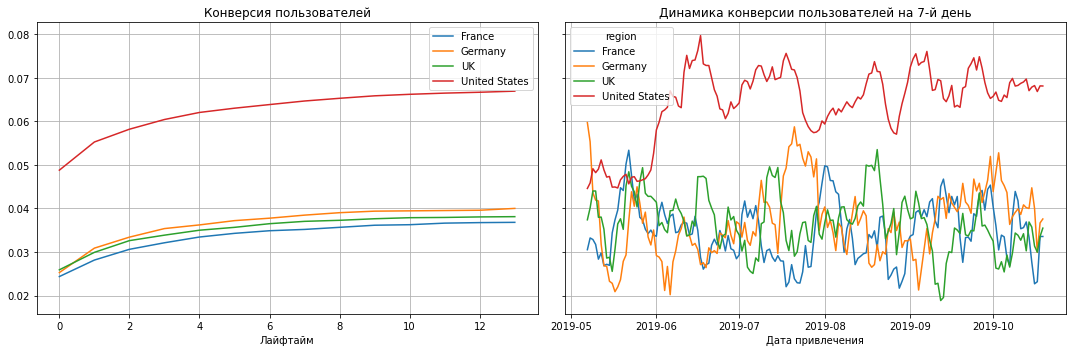

In [37]:
#разбивка по странам
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])
plot_conversion(conversion, conversion_history, 7)

Наивысший уровень конверсии демонстрируют пользователи из США, при этом всплеск конверсионной активности для пользователей из США пришёлся на июнь, для пользователей из Германии - на июль, для пользователей из Великобритании - на август, пользователи из Франции оказались наиболее активными в мае.

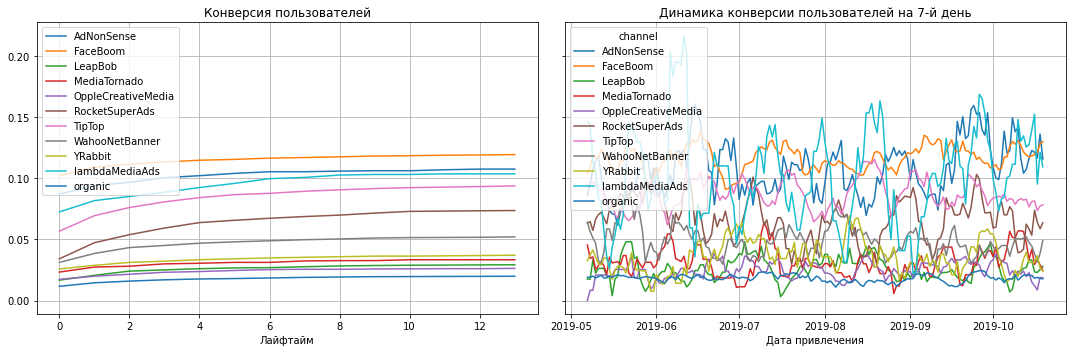

In [38]:
#разбивка по рекламным каналам
conversion_raw, conversion, conversion_history = get_conversion(profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel'])
plot_conversion(conversion, conversion_history, 7)

Наибольший уровень конверсии на каналах FaceBoom, AdNonSense, IambdaMediaAds и TipTop, "всплесков" конверсионной активности больше всего на канале IambdaMediaAds, особенно в мае-июне.

Попробуем ответить на поставленные вопросы:

1) Окупается ли реклама в целом? - Нет, в целом, реклама не окупается

2) Какие устройства, страны и каналы могут снижать окупаемость рекламы? - Как мы выяснили, окупаемость рекламы могут снижать устройства Apple, страна США и рекламный канал TipTop.

3) Чем могут быть вызваны проблемы окупаемости? - На наш взгляд, проблемы окупаемости могут быть вызваны некорректным распределением рекламных средств, их вкладывают в те рекламные каналы, которые приносят меньшую "пожизненную" ценность пользователей.

4) Опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

К возможным причинам обнаруженных проблем можно отнести:
- некорретное распределение рекламных средств, нужно пересмотреть бюджет рекламу по каналу TipTop, реклама на этом канале не окупилась за 13 месяцев, так быть не должно
- стоит внимательнее изучить рекламу, которая проходила на различных каналах после мая-июня, возможно, реклама вызвала противоречивые интерпретации у пользователя, в связи с чем после мая-июня расходы на рекламу в течение первых 7 дней перестали окупаться
- нужно пересмотреть рекламу для пользователей Apple, а также пользователей из США, так как реклама для этих пользователей не окупилась даже в течение 13 месяцев
- можно обратить внимание на рекламные каналы IambdaMediaAds и YRabbit, на первом канале довольно высокие показатели конверсии и неплохие показатели окупаемости, а второй канал также окупается очень хорошо и быстро(в течение первых 7 дней),а расходы на этот рекламный канал относительно невысокие.

# Общий вывод

Мы проанализировали данные о пользователях развлекательного приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года.
В ходе анализа выяснили, что:
- бОльшая часть пользователей "приходит" в приложение самостоятельно, т.е. органическим путём, при этом наименьшая часть из этих польвозателей конвертируется в платящих пользователей, наибольшее число платящих пользователей приходит с канала FaceBoom;
- чаще всего пользователи заходят в приложение с iPhone и Android, а платящие пользователи чаще заходят с Mac;
- наибольшее количество пользователей, как в общем, так и платящих, дают США, а Германия на последнем месте по общему количеству посетителей и на втором месте по количеству платящих пользователей;
- в общей сложности на рекламу было потрачено  примерно 105497,3 у.е., наибольший расход на рекламу на канале TipTop
- привлечение пользователей из различных рекламных каналов, в среднем, стоит 0.70 у.е.
- каждый клиент, в среднем, приносит 0.68 y.e.
- расходы на привлечение клиента окупаются в том случае, если стоимость привлечения клиента ниже его "пожизненно" ценности, таким образом расходы на привлечение клиента окупаются на каналах WahooNetBanner, OppleCreativeMedia
- на привлечение пользователей могут отрицательно повлиять такие факторы, как размещение на неудобных или непопулярных для пользователей каналах, некорректная адаптация приложения для разных устройств, разных стран.

Основной задачей исследования было выявление причин,почему несмотря на огромные вложения в рекламу развлекательного приложения Procrastinate Pro+, последние несколько месяцев компания терпит убытки, также разработка предложений для копмании, что помочь ей выйти в плюс.

Выделим причины неэффективности привлечения пользователей:
- некорректное привлечение пользователей после мая-июня 2019 года, по всем показателям экономики покупателя становится очевидно, что после июня либо была запущенна какая-то некорректная реклама, либо выбран не самый оптимальный рекламный канал, возможно это было вызвано непониманием целевой аудитории или использованием шаблонных коммерческих предложений в рекламе или ещё какими-либо факторами
- некорректно выбраны рекламные каналы, например, в качестве основного рекламного канала был выбран канал TipTop, расходы на который в 4 раза превысили средние расходы по всем каналам и более чем в 4 раза превысили среднюю "пожизненную ценность" пользователя, также много средств было вложено в рекламные каналы AdNonSense и lambdaMediaAds, стоимость привлечения на них выше средней, а количество привлечённых пользователей в разы меньше, чем на каналах с меньшей стоимостью привлечения (например, каналы WahooNetBanner, OppleCreativeMedia привлекают в 2-4 раза больше пользователей). 
- некорректно  выбрана целевая аудитория с точки зрения использования различных устройств, так, вероятнее всего, в расходах на рекламу был сделан основной упор на пользователей мобильных устройств iPhone и Android, при этом было выявлено, что платящие  чаще заходят в приложение с Mac, а не с телефона, возможно, что приложение для телефона не очень корректно работает с оплатами, поэтому мы видим такую статистику. Правда, при этом количество платящих пользователей, которые заходят в приложение с PC - наименьшее, так что, возможно, что приложение наиболее удобно именно для "яблочников", а не для пользователей устройств на базе Android, также было замечено, что инвестиции быстрее всего (на 7-й месяц) окупаются по пользователям PC и на 11 месяц по пользователям Android, а вот инвестиции по пользователям Mac, Android не окупаются даже по прошествии 13 месяцев, так что возможной причиной неэффективности привлечения пользователей была излишняя ориентация рекламы на пользователей Apple
- некорректно выбрана страна целевой аудитории, так, одной из возможных причин неблагоприятной ситуации может быть то, что основной упор в рекламе был сделан на пользователей из США, однако несмотря на то, что "пожизненная ценность" пользователей из США в разы выше "пожизненной ценности" представителей из Германии, Великобритании и, тем более, Франции, инвестиции на рекламу в США не окупаются по прошествии 13 месяцев, в то время, как в других странах(Великобритания, Германия, Франция) инвестиции окупаются спустя 2-3 месяца. 

Сформируем рекомендации для отдела маркетинга для повышения эффективности:
- разобраться с особенностями рекламных кампаний после мая-июня 2019 года, чтобы выявить, почему после этого периода показатели "пожизненной ценности", а также удержания и конверсии пользователей стали ухудшаться
- перенаправление рекламных расходов на менее дорогие, но не менее эффективные рекламные каналы (например, YRabbit вместо TipTop)
- перераспределение средств на рекламу и адаптация рекламных кампаний для различных типов устройств, возможно, имеет смысл, уменьшить количество расходов на рекламу для пользователей Apple в пользу увеличения рекламного бюджета для пользователей PC, Android
- проверить со службой разработчиков корректность работы приложений для мобильных телефонов, есть вероятность, что пользователям неудобно пользоваться платными сервисами с мобильных устройств.